In [11]:
from typing import List, Tuple, Optional

import os
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from karateclub.graph_embedding import Graph2Vec
from tqdm import tqdm

from master_thesis.utils import LOGLEVEL_MAP
from master_thesis.classification_models import *
from master_thesis.tools.data import  load_np_data, Preprocessing
from master_thesis.tools.plots import plot_sample_networks, plot_weight_histogram

logging.basicConfig(level=LOGLEVEL_MAP["INFO"])

SEED = 42
K_FOLDS = 10
# NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/Synthetic/ScaleFreeBias/networks"
# NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/Synthetic/ScaleFreeEasy/networks"
NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/NeuroFlicksRCC/networks"

# Load dataset

In [17]:
X, y = Preprocessing(undirected=False)(*load_np_data(NETWORKS_DIR_PATH, channel=0))

In [18]:
print(len(X), len(y))

449 449


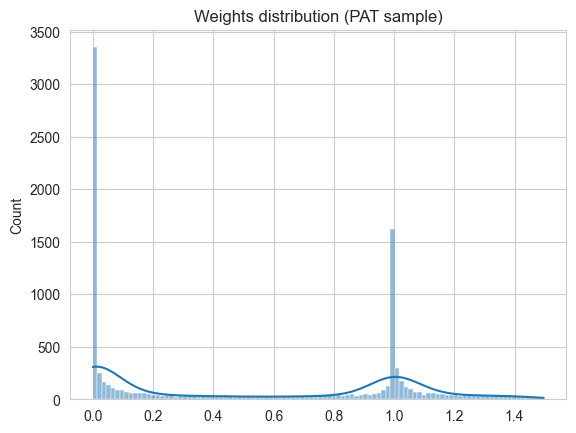

In [19]:
idx = 0
plot_weight_histogram(X[idx], y[idx])

### Plot sample class members

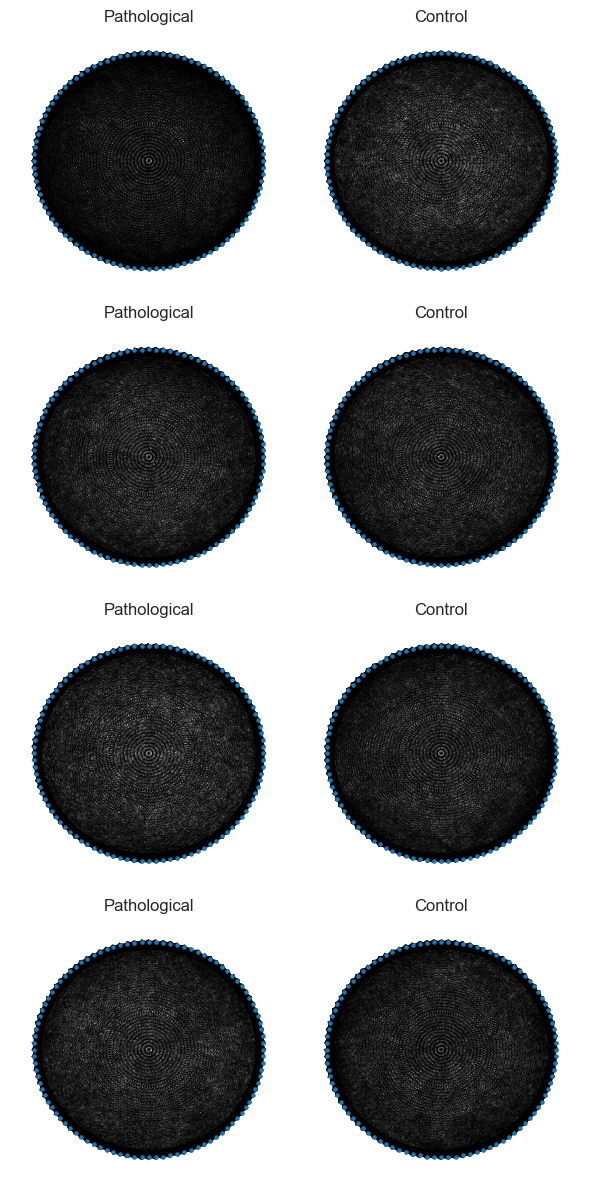

In [16]:
# Plot sample networks
plot_sample_networks(X, y, rows=4)

## Embedd networks (optionally)

In [5]:
# graph2vec = Graph2Vec(dimensions=32, wl_iterations=2, epochs=200, seed=SEED, workers=1)
# graph2vec.fit(X)
# X = graph2vec.get_embedding()

# Pipe through the LDP model

## Leave-one-out cross-validation

Cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

Cross-validation: 100%|██████████| 10/10 [01:02<00:00,  6.29s/it]

=== Evaluating model on train data ===


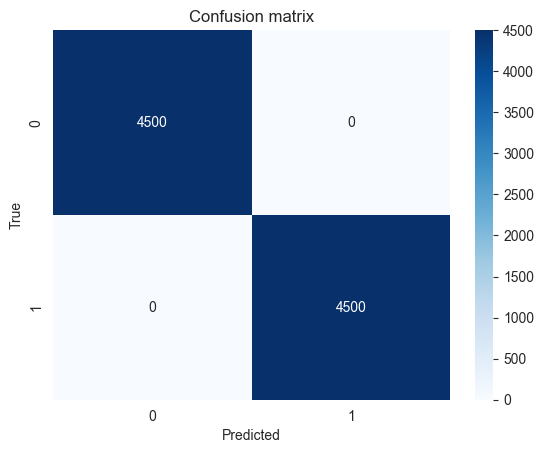

Accuracy:  1.00
Recall:    1.00
Precision: 1.00
f1 score:  1.00
AUC score: 1.00

=== Evaluating model on test data ====


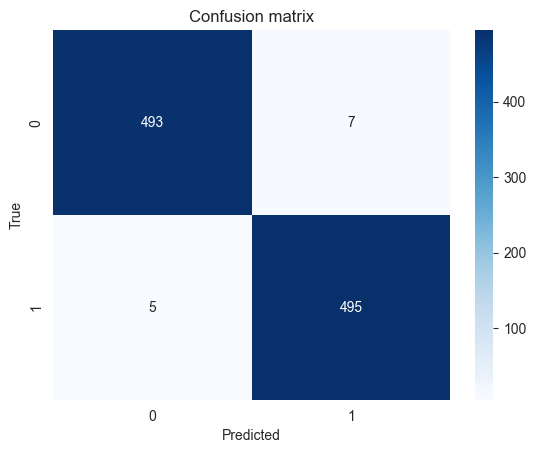

Accuracy:  0.99
Recall:    0.99
Precision: 0.99
f1 score:  0.99
AUC score: 0.99



<Figure size 640x480 with 0 Axes>

In [6]:
# Define accumulator lists
y_gold_train_acc, y_hat_train_acc = [], []
y_gold_test_acc, y_hat_test_acc = [], []

# Define k-fold cross-validation
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
for i, (train_index, test_index) in tqdm(enumerate(kfold.split(X)), total=K_FOLDS, desc="Cross-validation"):

    # Split data
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

    # Train model (Graph2Vec)
    # model = VectorModel()
    # model.fit(X_train, y_train)

    # Train model (LTP)
    model = LTPModel(log_degree=True)
    model.fit(X_train, y_train)

    # Predict
    y_hat_train = model.predict(X_train)
    y_hat_train_acc.append(y_hat_train)
    y_gold_train_acc.append(y_train)

    y_hat_test = model.predict(X_test)
    y_hat_test_acc.append(y_hat_test)
    y_gold_test_acc.append(y_test)

# Concatenate lists
y_hat_train = np.concatenate(y_hat_train_acc)
y_gold_train = np.concatenate(y_gold_train_acc)

y_hat_test = np.concatenate(y_hat_test_acc)
y_gold_test = np.concatenate(y_gold_test_acc)

# Evaluate classification
print("=== Evaluating model on train data ===")
print(BaseModel.evaluate(y_gold_train, y_hat_train, plot_cm=True))

print("=== Evaluating model on test data ====")
print(BaseModel.evaluate(y_gold_test, y_hat_test, plot_cm=True))

## Holdout

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

holdout_size = 0.2
holdout_size = int(holdout_size * len(X))

# Shuffle data
idx = np.arange(len(X))
np.random.shuffle(idx)
X = [X[i] for i in idx]
y = [y[i] for i in idx]

# Split data
X_train, X_test = X[:-holdout_size], X[-holdout_size:]
y_train, y_test = y[:-holdout_size], y[-holdout_size:]

# Train model
model = GCNModel(learning_rate=0.005, epochs=100, print_every=20, ldp_features=True)
model.fit(X_train, y_train)

=== Evaluating model on train data ===


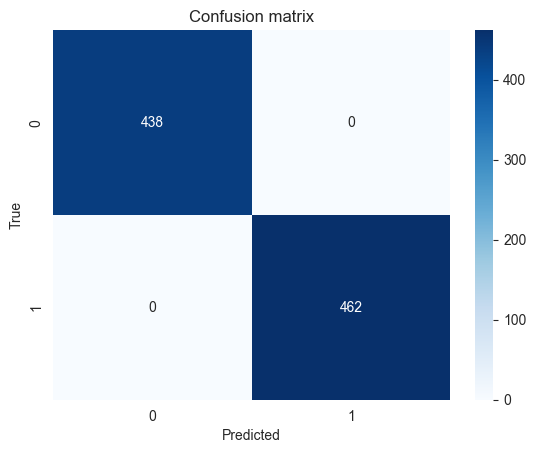

Accuracy:  1.00
Recall:    1.00
Precision: 1.00
f1 score:  1.00
AUC score: 1.00

=== Evaluating model on test data ====


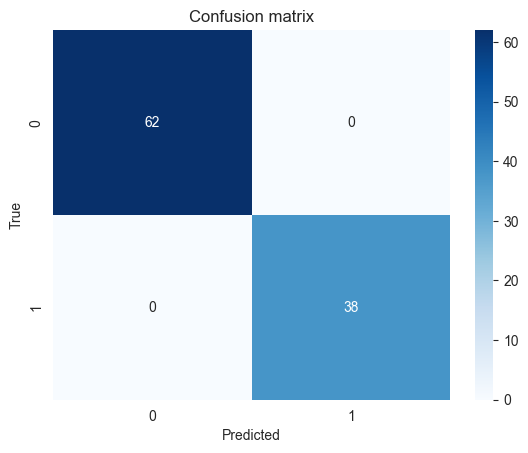

Accuracy:  1.00
Recall:    1.00
Precision: 1.00
f1 score:  1.00
AUC score: 1.00



<Figure size 640x480 with 0 Axes>

In [10]:
print("=== Evaluating model on train data ===")
y_hat_train = model.predict(X_train)
print(BaseModel.evaluate(np.array(y_train), y_hat_train, plot_cm=True))

print("=== Evaluating model on test data ====")
y_hat_test = model.predict(X_test)
print(BaseModel.evaluate(y_test, y_hat_test, plot_cm=True))